In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from collections import deque
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from scipy.stats import pearsonr, ks_2samp
from sklearn.metrics import r2_score
import numpy.polynomial.polynomial as poly

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:

# --------------------------
# Data Handling
# --------------------------
class DiabetesDataset(Dataset):
    """Processed diabetes management dataset."""
    
    def __init__(self, csv_file):
        # Load data and fill missing values
        df = pd.read_csv(csv_file)
        df = df.ffill().bfill()
        
        # Ensure key features have no missing values
        if df[["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob", "hour"]].isna().any().any():
            raise ValueError("Dataset contains NaN values after preprocessing")
        
        # Verify that action values are within [-1, 1]
        assert df["action"].between(-1, 1).all(), "Actions must be between -1 and 1"
        
        # Prepare state features and action values
        self.states = df[["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob", "hour"]].values.astype(np.float32)
        self.actions = df["action"].values.astype(np.float32).reshape(-1, 1)
        
        # Compute rewards from the glu_raw values
        self.rewards = self._compute_rewards(df["glu_raw"].values)
        
        # Create transitions: next_states via roll and done flags
        self.next_states = np.roll(self.states, -1, axis=0)
        self.dones = df["done"].values.astype(np.float32)
        
        # Remove last transition (invalid next state)
        self._sanitize_transitions()
    
    def _compute_rewards(self, glucose_next):
        """
        Compute rewards using a rescaled Risk Index (RI)-based function.
        Based on Kovatchev et al. (2005), extended with a severe hypoglycemia penalty.
        """
        glucose = np.clip(glucose_next.astype(np.float32), 10, 400)  # Clamp extreme values

        # Step 1: Risk transformation function
        log_glucose = np.log(glucose)
        f = 1.509 * (np.power(log_glucose, 1.084) - 5.381)
        r = 10 * np.square(f)

        # Step 2: LBGI and HBGI
        lbgi = np.where(f < 0, r, 0)
        hbgi = np.where(f > 0, r, 0)

        # Step 3: Total Risk Index (RI)
        ri = lbgi + hbgi

        # Step 4: Rescale RI and convert to reward
        normalized_ri = -ri / 10.0  # Stronger signal than /100
        rewards = np.clip(normalized_ri, -5.0, 0.0)

        # Step 5: Severe hypoglycemia penalty
        severe_hypo_penalty = np.where(glucose <= 39, -15.0, 0.0)
        rewards += severe_hypo_penalty

        # Step 6: Optional time penalty
        rewards -= 0.01  # Encourage faster correction

        return np.clip(rewards, -15.0, 0.0).astype(np.float32)


    
    def _sanitize_transitions(self):
        """Remove the last transition which lacks a valid next state."""
        valid_mask = np.ones(len(self.states), dtype=bool)
        valid_mask[-1] = False
        self.states = self.states[valid_mask]
        self.actions = self.actions[valid_mask]
        self.rewards = self.rewards[valid_mask]
        self.next_states = self.next_states[valid_mask]
        self.dones = self.dones[valid_mask]
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return {
            'state': torch.FloatTensor(self.states[idx]),
            'action': torch.FloatTensor(self.actions[idx]),
            'reward': torch.FloatTensor([self.rewards[idx]]),
            'next_state': torch.FloatTensor(self.next_states[idx]),
            'done': torch.FloatTensor([self.dones[idx]])
        }



In [5]:


# --------------------------
# Actor: Gaussian Policy Network
# --------------------------
class GaussianActor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=32):
        super().__init__()
        # Three dense layers with 32 units each
        self.fc1 = nn.Linear(state_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        # Separate output heads for mean and log_std
        self.mean_head = nn.Linear(hidden_units, action_dim)
        self.log_std_head = nn.Linear(hidden_units, action_dim)
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2
        
        # Initialize weights
        for layer in [self.fc1, self.fc2, self.fc3, self.mean_head, self.log_std_head]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)
        return mean, std
    
    def sample(self, state):
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        x_t = dist.rsample()  # Reparameterization trick
        action = torch.tanh(x_t)  # Squash to [-1, 1]
        # Compute log probability with tanh correction
        log_prob = dist.log_prob(x_t)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob

# --------------------------
# Critic: Q-Network
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=32):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, hidden_units)
        self.out = nn.Linear(hidden_units, 1)
        
        for layer in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q = self.out(x)
        return q



In [6]:

# --------------------------
# SAC Agent
# --------------------------
class SACAgent(nn.Module):
    """SAC agent with a Gaussian policy and twin Q-networks."""
    def __init__(self, state_dim=8, action_dim=1,
                 actor_lr=3e-4, critic_lr=3e-4, alpha_lr=3e-4,
                 target_entropy=-1, gamma=0.997, tau=0.005):
        super().__init__()
        self.gamma = gamma
        self.tau = tau
        self.target_entropy = target_entropy
        
        # Actor (policy) network
        self.actor = GaussianActor(state_dim, action_dim).to(device)
        
        # Twin Q-networks
        self.q1 = QNetwork(state_dim, action_dim).to(device)
        self.q2 = QNetwork(state_dim, action_dim).to(device)
        # Target networks
        self.q1_target = QNetwork(state_dim, action_dim).to(device)
        self.q2_target = QNetwork(state_dim, action_dim).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        # Entropy temperature (initialized to 0.1) as log_alpha for numerical stability
        self.log_alpha = torch.tensor([0.1], requires_grad=True, device=device)
        
        # Optimizers for actor, critic, and temperature
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=critic_lr)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=alpha_lr)
        
    def act(self, state):
        """Deterministic action for evaluation: use the mean and apply tanh."""
        mean, _ = self.actor.forward(state)
        return torch.tanh(mean)
    
    def update_targets(self):
        """Soft-update target networks."""
        with torch.no_grad():
            for target_param, param in zip(self.q1_target.parameters(), self.q1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for target_param, param in zip(self.q2_target.parameters(), self.q2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)



In [19]:


def train_saccql(dataset_path, epochs=200, batch_size=512, use_cql=False, cql_alpha=0.1):
    """
    Trains the SAC agent using the specified dataset, logs training metrics to a CSV file,
    and saves model checkpoints every 50 epochs.
    """
    dataset = DiabetesDataset(dataset_path)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    agent = SACAgent().to(device)

    # Open CSV file for logging training metrics
    csv_file = "training_metricsSACCQL.csv"
    with open(csv_file, mode='w', newline='') as file:
        csv_writer = csv.writer(file)
        # Write CSV header
        csv_writer.writerow([
            "epoch", "critic_loss", "actor_loss", "alpha_loss", "alpha_value",
            "cql_penalty", "avg_q", "avg_entropy", "actions_mean", "actions_std"
        ])

        # Main training loop
        for epoch in range(epochs):
            # Initialize epoch-level metrics
            epoch_critic_loss = 0.0
            epoch_actor_loss = 0.0
            epoch_alpha_loss = 0.0
            epoch_q_val = 0.0
            epoch_entropy = 0.0
            epoch_cql_penalty = 0.0
            num_batches = 0

            # List for diagnostic statistics (actions)
            epoch_actions_list = []

            for batch in dataloader:
                num_batches += 1
                
                states      = batch['state'].to(device)
                actions     = batch['action'].to(device)
                rewards     = batch['reward'].to(device)
                next_states = batch['next_state'].to(device)
                dones       = batch['done'].to(device)

                # ---------- Critic Update ----------
                with torch.no_grad():
                    next_actions, next_log_probs = agent.actor.sample(next_states)
                    q1_next = agent.q1_target(next_states, next_actions)
                    q2_next = agent.q2_target(next_states, next_actions)
                    min_q_next = torch.min(q1_next, q2_next) - torch.exp(agent.log_alpha) * next_log_probs
                    target_q = rewards + agent.gamma * (1 - dones) * min_q_next
                    # Clip the target Q-value to prevent divergence
                    target_q = torch.clamp(target_q, min=-10.0, max=5.0)

                current_q1 = agent.q1(states, actions)
                current_q2 = agent.q2(states, actions)
                critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

                if use_cql:
                    # Generate random actions
                    random_actions = torch.empty_like(actions).uniform_(-1.0, 1.0)

                    # Get policy actions from the actor
                    policy_output = agent.actor(states)
                    policy_actions = policy_output[0] if isinstance(policy_output, tuple) else policy_output

                    # Compute Q-values for policy and random actions
                    q1_policy = agent.q1(states, policy_actions)
                    q2_policy = agent.q2(states, policy_actions)
                    q1_rand = agent.q1(states, random_actions)
                    q2_rand = agent.q2(states, random_actions)
                    q1_data = current_q1  
                    q2_data = current_q2

                    # Concatenate Q-values for log-sum-exp computation
                    q1_cat = torch.cat([q1_rand, q1_policy, q1_data], dim=0)
                    q2_cat = torch.cat([q2_rand, q2_policy, q2_data], dim=0)
                    q1_lse = torch.logsumexp(q1_cat, dim=0)
                    q2_lse = torch.logsumexp(q2_cat, dim=0)

                    # Compute and add the CQL penalty to the critic loss
                    cql_penalty = ((q1_lse.mean() - q1_data.mean()) + (q2_lse.mean() - q2_data.mean()))
                    critic_loss += cql_alpha * cql_penalty
                else:
                    cql_penalty = torch.tensor(0.0)

                agent.critic_optim.zero_grad()
                critic_loss.backward()
                agent.critic_optim.step()

                # ---------- Actor Update ----------
                new_actions, log_probs = agent.actor.sample(states)
                q1_val = agent.q1(states, new_actions)
                q2_val = agent.q2(states, new_actions)
                min_q_val = torch.min(q1_val, q2_val)
                actor_loss = (torch.exp(agent.log_alpha) * log_probs - min_q_val).mean()
                # L2 regularization on actor parameters
                l2_reg = 1e-4 * sum(torch.sum(p ** 2) for p in agent.actor.parameters())
                actor_loss += l2_reg

                agent.actor_optim.zero_grad()
                actor_loss.backward()
                agent.actor_optim.step()

                # ---------- Temperature (Alpha) Update ----------
                alpha_loss = -(agent.log_alpha * (log_probs + agent.target_entropy).detach()).mean()
                agent.alpha_optim.zero_grad()
                alpha_loss.backward()
                agent.alpha_optim.step()
                with torch.no_grad():
                    agent.log_alpha.data.clamp_(min=np.log(0.1), max=np.log(2.0))

                # Accumulate metrics for logging
                epoch_critic_loss += critic_loss.item()
                epoch_actor_loss  += actor_loss.item()
                epoch_alpha_loss  += alpha_loss.item()
                epoch_q_val       += min_q_val.mean().item()
                epoch_entropy     += (-log_probs).mean().item()
                epoch_cql_penalty += cql_penalty.item()

                # ---------- Diagnostic: Action Statistics ----------
                with torch.no_grad():
                    sampled_actions, _ = agent.actor.sample(states)
                    epoch_actions_list.append(sampled_actions.detach().cpu())

                agent.update_targets()

            # Compute aggregated statistics for this epoch
            all_actions = torch.cat(epoch_actions_list, dim=0)
            actions_mean = all_actions.mean().item()
            actions_std = all_actions.std().item()

            with torch.no_grad():
                alpha_value = torch.exp(agent.log_alpha).item()

            # Calculate averages over batches
            avg_critic_loss = epoch_critic_loss / num_batches
            avg_actor_loss  = epoch_actor_loss  / num_batches
            avg_alpha_loss  = epoch_alpha_loss  / num_batches
            avg_q         = epoch_q_val       / num_batches
            avg_entropy   = epoch_entropy     / num_batches
            avg_cql_penalty = epoch_cql_penalty / num_batches

            # Write metrics to CSV
            csv_writer.writerow([
                epoch + 1, avg_critic_loss, avg_actor_loss, avg_alpha_loss, alpha_value,
                avg_cql_penalty, avg_q, avg_entropy, actions_mean, actions_std
            ])

            # Save the model checkpoint every 50 epochs
            if (epoch + 1) % 50 == 0:
                checkpoint_filename = f"modelSACCQL_epoch_{epoch + 1}.pt"
                torch.save(agent.state_dict(), checkpoint_filename)
                print(f"Checkpoint saved: {checkpoint_filename}")

    return agent



In [20]:
agent = train_saccql(dataset_path="datasets/processed/full-training.csv",use_cql=True,cql_alpha=0.1)

Checkpoint saved: modelSACCQL_epoch_50.pt
Checkpoint saved: modelSACCQL_epoch_100.pt
Checkpoint saved: modelSACCQL_epoch_150.pt
Checkpoint saved: modelSACCQL_epoch_200.pt


In [8]:

def plot_training_metrics(csv_file="training_metrics.csv"):
    """
    Reads the training metrics CSV file and plots the metrics over epochs.
    """
    df = pd.read_csv(csv_file)
    epochs = df["epoch"]

    plt.figure()
    plt.plot(epochs, df["critic_loss"], label="Critic Loss")
    plt.plot(epochs, df["actor_loss"], label="Actor Loss")
    plt.plot(epochs, df["alpha_loss"], label="Alpha Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, df["alpha_value"], label="Alpha (exp)")
    plt.xlabel("Epoch")
    plt.ylabel("Alpha Value")
    plt.title("Temperature over Training")
    plt.legend()
    plt.show()

    # Additional plots can be added for cql_penalty, avg_q, avg_entropy, etc.



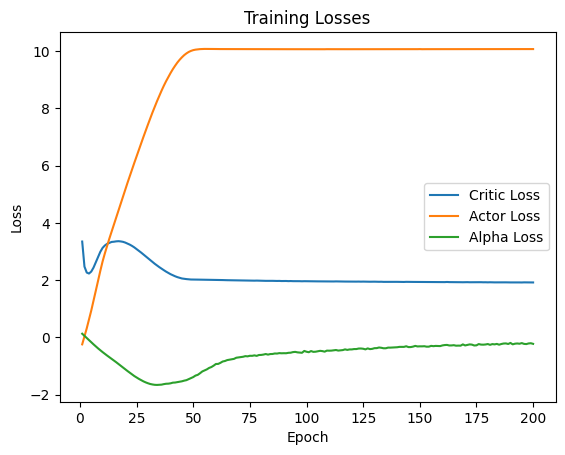

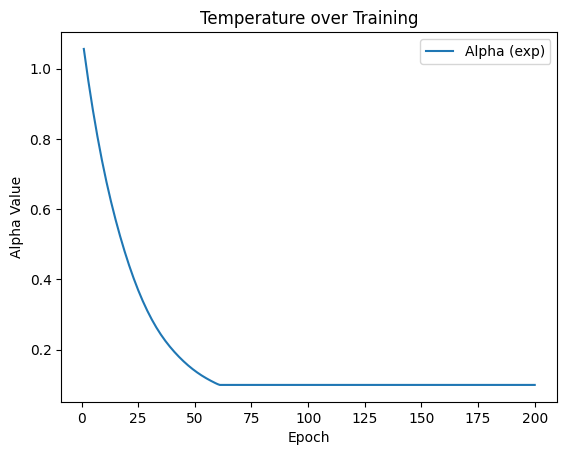

In [21]:
plot_training_metrics(csv_file="training_metricsSACCQL.csv")

In [120]:
agent_new = train_sac3(dataset_path="datasets/processed/563-training.csv",use_cql=True,cql_alpha=0.1)
torch.save(agent_new.state_dict(), "sac_new.pth")

Epoch 1/100: Critic Loss: 1.9681, Actor Loss: -0.5341, Alpha Loss: 0.1520, Alpha (exp): 1.0880, CQL: 13.3777, Avg Q: -0.1677, Avg Entropy: 0.6473, Actions (mean,std): (0.0042,0.6020)
Epoch 2/100: Critic Loss: 1.6632, Actor Loss: -0.7164, Alpha Loss: 0.1280, Alpha (exp): 1.0710, CQL: 13.4378, Avg Q: -0.0002, Avg Entropy: 0.6711, Actions (mean,std): (0.0249,0.5934)
Epoch 3/100: Critic Loss: 1.5850, Actor Loss: -0.8163, Alpha Loss: 0.1022, Alpha (exp): 1.0543, CQL: 13.4828, Avg Q: 0.1029, Avg Entropy: 0.6788, Actions (mean,std): (0.0036,0.5937)
Epoch 4/100: Critic Loss: 1.5483, Actor Loss: -0.8814, Alpha Loss: 0.0757, Alpha (exp): 1.0379, CQL: 13.5060, Avg Q: 0.1807, Avg Entropy: 0.6773, Actions (mean,std): (0.0027,0.5932)
Epoch 5/100: Critic Loss: 1.5276, Actor Loss: -0.9306, Alpha Loss: 0.0495, Alpha (exp): 1.0217, CQL: 13.5333, Avg Q: 0.2384, Avg Entropy: 0.6797, Actions (mean,std): (-0.0101,0.5912)
Epoch 6/100: Critic Loss: 1.5196, Actor Loss: -0.9720, Alpha Loss: 0.0232, Alpha (exp):

In [113]:

def evaluateX_sac_policy(model_pth_path, test_csv_path, device='cpu', batch_size=256):
    # 1. Initialize a fresh agent instance and load the weights
    agent = SACAgent().to(device)
    agent.load_state_dict(torch.load(model_pth_path, map_location=device))
    agent.eval()  # set to evaluation mode

    # 2. Load the test dataset (assuming DiabetesDataset is defined/imported)
    test_dataset = DiabetesDataset(test_csv_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Accumulators for metrics and predictions
    total_q = 0.0
    total_count = 0
    predicted_actions_all = []
    actual_actions_all = []
    # (We'll no longer accumulate Q-values for plotting)

    with torch.no_grad():
        for batch in test_loader:
            states = batch["state"].to(device)
            actual_actions = batch["action"].to(device)
            
            # Use deterministic action for evaluation (tanh(mean))
            predicted_actions = agent.act(states)
            
            # Compute Q-values for logging (optional)
            q1_vals = agent.q1(states, predicted_actions)
            q2_vals = agent.q2(states, predicted_actions)
            min_q_vals = torch.min(q1_vals, q2_vals)
            
            total_q += min_q_vals.sum().item()
            total_count += states.size(0)
            
            predicted_actions_all.append(predicted_actions.cpu().numpy())
            actual_actions_all.append(actual_actions.cpu().numpy())
    
    avg_q = total_q / total_count if total_count > 0 else 0.0
    predicted_actions_all = np.concatenate(predicted_actions_all, axis=0)
    actual_actions_all = np.concatenate(actual_actions_all, axis=0)

    # Compute standard metrics
    pred_action_mean = float(predicted_actions_all.mean())
    pred_action_std  = float(predicted_actions_all.std())
    actual_action_mean = float(actual_actions_all.mean())
    actual_action_std  = float(actual_actions_all.std())
    mse = np.mean((predicted_actions_all - actual_actions_all)**2)
    corr, _ = pearsonr(actual_actions_all.flatten(), predicted_actions_all.flatten())
    r2 = r2_score(actual_actions_all.flatten(), predicted_actions_all.flatten())
    ks_stat, ks_pval = ks_2samp(actual_actions_all.flatten(), predicted_actions_all.flatten())
    
    # Compute linear regression for scatter plot: predicted = slope * actual + intercept
    slope, intercept = np.polyfit(actual_actions_all.flatten(), predicted_actions_all.flatten(), 1)
    # Regression line over the range of actual actions
    x_vals = np.linspace(-1, 1, 100)
    reg_line = slope * x_vals + intercept

    # Print evaluation metrics
    print("Offline Evaluation (test set):")
    print(f"  Average Q(s, pi(s)): {avg_q:.4f}")
    print(f"  Predicted Actions -> mean: {pred_action_mean:.4f}, std: {pred_action_std:.4f}")
    print(f"  Actual Actions    -> mean: {actual_action_mean:.4f}, std: {actual_action_std:.4f}")
    print(f"  MSE between predicted and actual actions: {mse:.4f}")
    print(f"  Pearson Correlation: {corr:.4f}")
    print(f"  R^2 Score: {r2:.4f}")
    print(f"  KS-Test: statistic={ks_stat:.4f}, p-value={ks_pval:.4f}")
    print(f"  Linear Regression: slope={slope:.4f}, intercept={intercept:.4f}")

    # --------- Plotting -----------
    plt.figure(figsize=(16, 14))
    
    # (A) Histograms for action distributions
    plt.subplot(3, 2, 1)
    plt.hist(predicted_actions_all, bins=50, alpha=0.6, label='Predicted', color='blue')
    plt.hist(actual_actions_all, bins=50, alpha=0.6, label='Actual', color='orange')
    plt.title("Action Distributions")
    plt.xlabel("Insulin Dose (normalized)")
    plt.ylabel("Frequency")
    plt.legend()
    
    # (B) Scatter plot: Actual vs. Predicted Actions with Regression
    plt.subplot(3, 2, 2)
    plt.scatter(actual_actions_all, predicted_actions_all, alpha=0.3, label='Data Points')
    plt.plot([-1, 1], [-1, 1], 'r--', label='Ideal (y=x)')
    plt.plot(x_vals, reg_line, 'k-', linewidth=2, label='Regression Line')
    plt.xlabel("Actual Action")
    plt.ylabel("Predicted Action")
    plt.title("Actual vs. Predicted Actions")
    plt.legend()
    
    # (C) Residuals Histogram (Predicted - Actual)
    residuals = predicted_actions_all - actual_actions_all
    plt.subplot(3, 2, 3)
    plt.hist(residuals, bins=50, alpha=0.7, color='green')
    plt.title("Residuals Histogram (Predicted - Actual)")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    
    # (D) Residuals vs. Actual Actions
    plt.subplot(3, 2, 4)
    plt.scatter(actual_actions_all, residuals, alpha=0.3, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual Action")
    plt.ylabel("Residual")
    plt.title("Residuals vs. Actual Action")
    
    # (E) Heatmap: Predicted Action vs. Heart Rate and Hour
    # Create a 2D grid by varying heart rate and hour while fixing other state features at their mean.
    # Assume test_dataset.states is a numpy array of shape (num_samples, 8) with features ordered as:
    # [Glucose, Glucose Deriv, Glucose Trend, Heart Rate, HR Deriv, HR Trend, Insulin on Board, Hour]
    states_all = test_dataset.states  # shape: (N, 8)
    mean_state = np.mean(states_all, axis=0)
    # Define grid ranges for Heart Rate (index 3) and Hour (index 7)
    hr_min, hr_max = states_all[:, 3].min(), states_all[:, 5].max()
    glu_min, glu_max = states_all[:, 0].min(), states_all[:, 0].max()
    hr_grid = np.linspace(hr_min, hr_max, 100)
    glu_grid = np.linspace(glu_min, glu_max, 100)
    HR, GLU = np.meshgrid(hr_grid, glu_grid)
    # Prepare grid states: for each (HR, Hour) pair, set that dimension and fix others to mean
    grid_states = np.tile(mean_state, (HR.size, 1))  # shape (N_grid, 8)
    grid_states[:, 3] = HR.flatten()   # update heart rate
    grid_states[:, 0] = GLU.flatten() # update hour
    grid_states_tensor = torch.tensor(grid_states, dtype=torch.float32).to(device)
    with torch.no_grad():
        grid_pred_actions = agent.act(grid_states_tensor).cpu().numpy().reshape(HR.shape)
    plt.subplot(3, 2, 5)
    plt.contourf(HR, GLU, grid_pred_actions, 50, cmap='viridis')
    plt.colorbar(label='Predicted Insulin Dose')
    plt.xlabel("Heart Rate (normalized)")
    plt.ylabel("Glucose (normalized)")
    plt.title("Heatmap: Predicted Action vs. Heart Rate and Glucose Level")



    # (E) State-Action Heatmap for a key modality (e.g. Glucose)
    # For this, we need to vary one state feature while fixing others to their mean.
    # Assume index 0 corresponds to glucose in the state vector.
    state_grid = np.linspace(test_dataset.states[:,0].min(), test_dataset.states[:,0].max(), 100)
    # Fix other state features at their mean (assuming test_dataset.states exists and is a numpy array)
    fixed_state = np.mean(test_dataset.states, axis=0)
    heatmap_actions = []
    for val in state_grid:
        temp_state = fixed_state.copy()
        temp_state[0] = val  # Vary glucose
        temp_state_tensor = torch.tensor(temp_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            act_val = agent.act(temp_state_tensor).cpu().numpy()[0,0]
        heatmap_actions.append(act_val)
    
    plt.subplot(3, 2, 6)
    plt.plot(state_grid, heatmap_actions, 'b-', linewidth=2)
    plt.xlabel("Glucose (normalized)")
    plt.ylabel("Predicted Insulin Dose")
    plt.title("State-Action Sensitivity (varying Glucose)")
    
    plt.tight_layout()
    plt.show()




    sensitivities = []
    agent.actor.train()  # temporarily set to train mode for gradient computation
    for i in range(len(test_dataset)):
        state = torch.tensor(test_dataset.states[i:i+1], dtype=torch.float32, requires_grad=True).to(device)
        action = agent.act(state)
        action.backward()  # backpropagate to compute gradients w.r.t state
        grad = state.grad.cpu().numpy()[0]  # gradient for this sample
        sensitivities.append(grad)

    sensitivities = np.array(sensitivities)
    avg_sensitivities = np.mean(np.abs(sensitivities), axis=0)

    # Normalize to percentages
    total = np.sum(avg_sensitivities)
    percent_sensitivities = (avg_sensitivities / total) * 100

    feature_names = ["Glucose", "Glucose Derivative", "Glucose Trend", "Heart Rate", "Heart Rate Derivative", "Heart Rate Trend", "Insulin on Board", "Hour of Day"]

    # Plotting
    plt.figure(figsize=(10, 5))
    bars = plt.bar(feature_names, percent_sensitivities, color='red')
    plt.xlabel("State Modality")
    plt.ylabel("Percentage Contribution (%)")
    plt.title("Feature Influence on Predicted Insulin Dose for Model HR")
    plt.xticks(rotation=45)

    # Annotate bars with percentage values
    for bar, perc in zip(bars, percent_sensitivities):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    agent.actor.eval()

 

    return


Offline Evaluation (test set):
  Average Q(s, pi(s)): -9.9713
  Predicted Actions -> mean: -0.3353, std: 0.1551
  Actual Actions    -> mean: -0.3082, std: 0.2077
  MSE between predicted and actual actions: 0.0175
  Pearson Correlation: 0.7830
  R^2 Score: 0.5947
  KS-Test: statistic=0.0843, p-value=0.0000
  Linear Regression: slope=0.5847, intercept=-0.1551


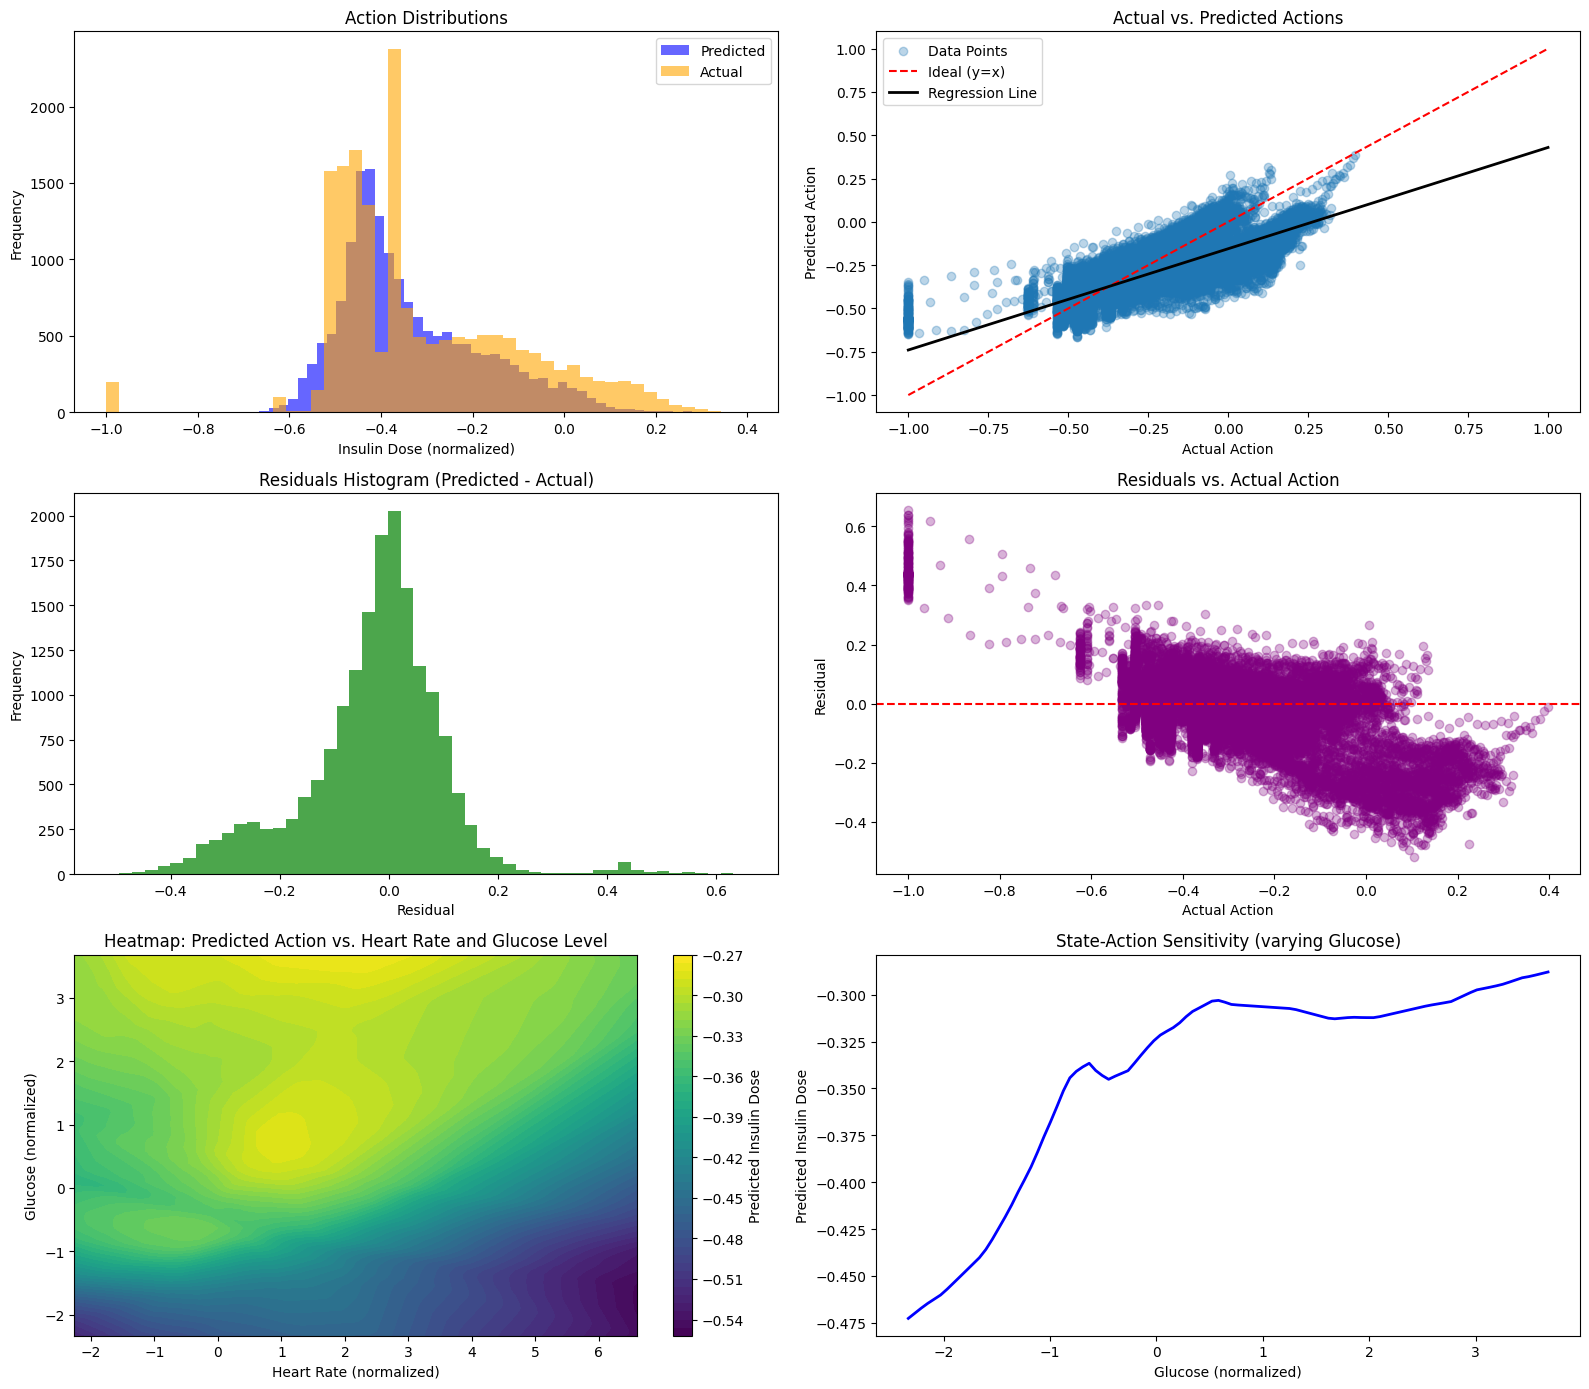

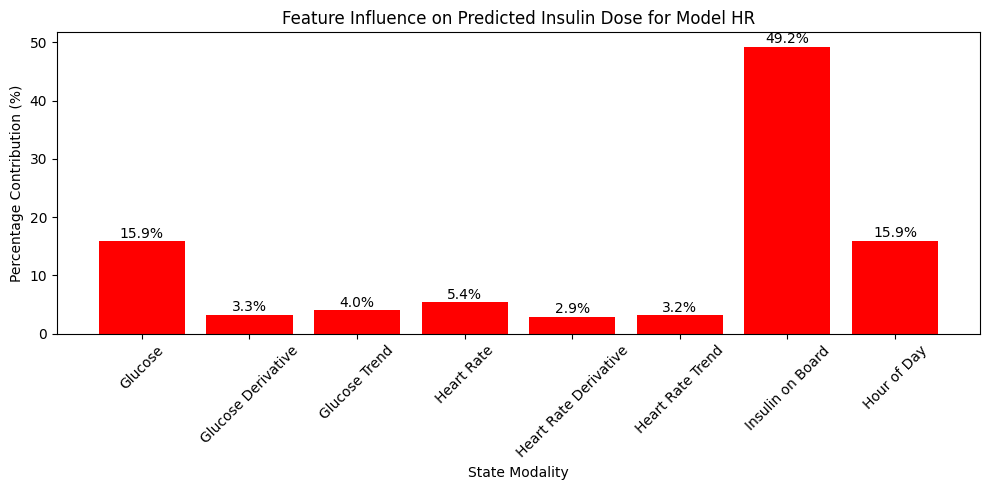

In [114]:
evaluateX_sac_policy("modelSACCQL_epoch_200.pt", "datasets/processed/full-testing.csv", device='cpu', batch_size=256)

In [27]:

class DiabetesDataset2(Dataset):
    """Processed diabetes management dataset."""
    
    def __init__(self, csv_file):
        # Load data and fill missing values
        df = pd.read_csv(csv_file)
        df = df.ffill().bfill()
        
        # Ensure key features have no missing values
        if df[["glu", "glu_d", "glu_t", "hr", "hr_d", "hr_t", "iob", "hour"]].isna().any().any():
            raise ValueError("Dataset contains NaN values after preprocessing")
        
        # Verify that action values are within [-1, 1]
        assert df["action"].between(-1, 1).all(), "Actions must be between -1 and 1"
        
        # Prepare state features and action values
        self.states = df[["glu", "glu_d", "glu_t", "iob", "hour"]].values.astype(np.float32)
        self.actions = df["action"].values.astype(np.float32).reshape(-1, 1)
        
        # Compute rewards from the glu_raw values
        self.rewards = self._compute_rewards(df["glu_raw"].values)
        
        # Create transitions: next_states via roll and done flags
        self.next_states = np.roll(self.states, -1, axis=0)
        self.dones = df["done"].values.astype(np.float32)
        
        # Remove last transition (invalid next state)
        self._sanitize_transitions()
    
    def _compute_rewards(self, glucose_next):
        """
        Compute rewards using a rescaled Risk Index (RI)-based function.
        Based on Kovatchev et al. (2005), extended with a severe hypoglycemia penalty.
        """
        glucose = np.clip(glucose_next.astype(np.float32), 10, 400)  # Clamp extreme values

        # Step 1: Risk transformation function
        log_glucose = np.log(glucose)
        f = 1.509 * (np.power(log_glucose, 1.084) - 5.381)
        r = 10 * np.square(f)

        # Step 2: LBGI and HBGI
        lbgi = np.where(f < 0, r, 0)
        hbgi = np.where(f > 0, r, 0)

        # Step 3: Total Risk Index (RI)
        ri = lbgi + hbgi

        # Step 4: Rescale RI and convert to reward
        normalized_ri = -ri / 10.0  # Stronger signal than /100
        rewards = np.clip(normalized_ri, -5.0, 0.0)

        # Step 5: Severe hypoglycemia penalty
        severe_hypo_penalty = np.where(glucose <= 39, -15.0, 0.0)
        rewards += severe_hypo_penalty

        # Step 6: Optional time penalty
        rewards -= 0.01  # Encourage faster correction

        return np.clip(rewards, -15.0, 0.0).astype(np.float32)


    
    def _sanitize_transitions(self):
        """Remove the last transition which lacks a valid next state."""
        valid_mask = np.ones(len(self.states), dtype=bool)
        valid_mask[-1] = False
        self.states = self.states[valid_mask]
        self.actions = self.actions[valid_mask]
        self.rewards = self.rewards[valid_mask]
        self.next_states = self.next_states[valid_mask]
        self.dones = self.dones[valid_mask]
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return {
            'state': torch.FloatTensor(self.states[idx]),
            'action': torch.FloatTensor(self.actions[idx]),
            'reward': torch.FloatTensor([self.rewards[idx]]),
            'next_state': torch.FloatTensor(self.next_states[idx]),
            'done': torch.FloatTensor([self.dones[idx]])
        }

In [28]:
# --------------------------
# SAC Agent
# --------------------------
class SACAgent2(nn.Module):
    """SAC agent with a Gaussian policy and twin Q-networks."""
    def __init__(self, state_dim=5, action_dim=1,
                 actor_lr=3e-4, critic_lr=3e-4, alpha_lr=3e-4,
                 target_entropy=-1, gamma=0.997, tau=0.005):
        super().__init__()
        self.gamma = gamma
        self.tau = tau
        self.target_entropy = target_entropy
        
        # Actor (policy) network
        self.actor = GaussianActor(state_dim, action_dim).to(device)
        
        # Twin Q-networks
        self.q1 = QNetwork(state_dim, action_dim).to(device)
        self.q2 = QNetwork(state_dim, action_dim).to(device)
        # Target networks
        self.q1_target = QNetwork(state_dim, action_dim).to(device)
        self.q2_target = QNetwork(state_dim, action_dim).to(device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        # Entropy temperature (initialized to 0.1) as log_alpha for numerical stability
        self.log_alpha = torch.tensor([0.1], requires_grad=True, device=device)
        
        # Optimizers for actor, critic, and temperature
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(list(self.q1.parameters()) + list(self.q2.parameters()), lr=critic_lr)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=alpha_lr)
        
    def act(self, state):
        """Deterministic action for evaluation: use the mean and apply tanh."""
        mean, _ = self.actor.forward(state)
        return torch.tanh(mean)
    
    def update_targets(self):
        """Soft-update target networks."""
        with torch.no_grad():
            for target_param, param in zip(self.q1_target.parameters(), self.q1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for target_param, param in zip(self.q2_target.parameters(), self.q2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [90]:
def evaluate_model2(model_path,test_csv_path,device='cuda', batch_size=256):
    agent = SACAgent2().to(device)
    agent.load_state_dict(torch.load(model_path, map_location=device))
    agent.eval()

    test_dataset = DiabetesDataset2(test_csv_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    total_q = 0.0
    total_count = 0
    predicted_actions_all = []
    actual_actions_all = []

    with torch.no_grad():
        for batch in test_loader:
            states = batch["state"].to(device)
            actual_actions = batch["action"].to(device)
            predicted_actions = agent.act(states)
            q_vals = torch.min(agent.q1(states, predicted_actions), agent.q2(states, predicted_actions))

            total_q += q_vals.sum().item()
            total_count += states.size(0)

            predicted_actions_all.append(predicted_actions.cpu().numpy())
            actual_actions_all.append(actual_actions.cpu().numpy())

    avg_q = total_q / total_count if total_count > 0 else 0.0
    predicted = np.concatenate(predicted_actions_all, axis=0)
    actual = np.concatenate(actual_actions_all, axis=0)

    mse = np.mean((predicted - actual) ** 2)
    corr, _ = pearsonr(actual.flatten(), predicted.flatten())
    r2 = r2_score(actual.flatten(), predicted.flatten())
    slope, intercept = np.polyfit(actual.flatten(), predicted.flatten(), 1)

    return agent,{
        "predicted": predicted,
        "actual": actual,
        "avg_q": avg_q,
        "mse": mse,
        "corr": corr,
        "r2": r2,
        "slope": slope,
        "intercept": intercept
    }

In [91]:
def evaluate_model(model_path,test_csv_path,device='cuda', batch_size=256):
    agent = SACAgent().to(device)
    agent.load_state_dict(torch.load(model_path, map_location=device))
    agent.eval()

    test_dataset = DiabetesDataset(test_csv_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    total_q = 0.0
    total_count = 0
    predicted_actions_all = []
    actual_actions_all = []

    with torch.no_grad():
        for batch in test_loader:
            states = batch["state"].to(device)
            actual_actions = batch["action"].to(device)
            predicted_actions = agent.act(states)
            q_vals = torch.min(agent.q1(states, predicted_actions), agent.q2(states, predicted_actions))

            total_q += q_vals.sum().item()
            total_count += states.size(0)

            predicted_actions_all.append(predicted_actions.cpu().numpy())
            actual_actions_all.append(actual_actions.cpu().numpy())

    avg_q = total_q / total_count if total_count > 0 else 0.0
    predicted = np.concatenate(predicted_actions_all, axis=0)
    actual = np.concatenate(actual_actions_all, axis=0)

    mse = np.mean((predicted - actual) ** 2)
    corr, _ = pearsonr(actual.flatten(), predicted.flatten())
    r2 = r2_score(actual.flatten(), predicted.flatten())
    slope, intercept = np.polyfit(actual.flatten(), predicted.flatten(), 1)

    return agent,{
        "predicted": predicted,
        "actual": actual,
        "avg_q": avg_q,
        "mse": mse,
        "corr": corr,
        "r2": r2,
        "slope": slope,
        "intercept": intercept
    }

In [92]:
def get_heatmap_actions(model_path,agent,test_dataset):
    state_grid = np.linspace(test_dataset.states[:, 0].min(), test_dataset.states[:, 0].max(), 100)
    fixed_state = np.mean(test_dataset.states, axis=0)
    agent.load_state_dict(torch.load(model_path, map_location=device))
    agent.eval()
    values = []
    for val in state_grid:
        state = fixed_state.copy()
        state[0] = val
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action = agent.act(state_tensor).cpu().numpy()[0, 0]
        values.append(action)
    return values,state_grid

In [108]:
def compare_two_models(model1_path, model2_path, test_csv_path, device='cuda', batch_size=256):


    # Evaluate both models
    agent1, result1 = evaluate_model(model1_path, test_csv_path, device, batch_size)
    agent2, result2 = evaluate_model2(model2_path, test_csv_path,  device, batch_size)

    # Plotting comparison
    plt.figure(figsize=(8, 12))

    # (1) Action Distributions
    plt.subplot(3, 1, 1)
    plt.hist(result1["actual"], bins=50, alpha=0.6, label='Actual Actions', color='black')
    plt.hist(result1["predicted"], bins=50, alpha=0.6, label='Predicted Actions (HR)',color='red')
    plt.hist(result2["predicted"], bins=50, alpha=0.6, label='Prediction Actions (no-HR)',color='blue')
  
    
    plt.title("Action Distributions")
    plt.xlabel("Action")
    plt.ylabel("Frequency")
    plt.legend()

    # (2) Scatter Plots
    plt.subplot(3, 1, 2)
    plt.scatter(result1["actual"], result1["predicted"], alpha=0.3, label='Model HR', color='red')
    plt.scatter(result2["actual"], result2["predicted"], alpha=0.3, label='Model no-HR', color='blue')
    plt.plot([-1, 1], [-1, 1], 'g--', label='Ideal')
    x_vals = np.linspace(-1, 1, 100)
    plt.plot(x_vals, result1["slope"] * x_vals + result1["intercept"], 'r-', label='Model HR Fit')
    plt.plot(x_vals, result2["slope"] * x_vals + result2["intercept"], 'b-', label='Model no-HR Fit')
    plt.title("Actual vs Predicted Actions")
    plt.xlabel("Actual Action")
    plt.ylabel("Predicted Action")
    plt.legend()


    # (4) Heatmap Sensitivity (varying Glucose)
    test_dataset1 = DiabetesDataset(test_csv_path)
    actions1,grid1 = get_heatmap_actions(model1_path,agent1,test_dataset1)

    test_dataset2 = DiabetesDataset2(test_csv_path)
    actions2,grid2 = get_heatmap_actions(model2_path,agent2,test_dataset2)

    plt.subplot(3, 1, 3)
    plt.plot(grid1, actions1, label='Model HR', color='red')
    plt.plot(grid2, actions2, label='Model no-HR', color='blue')
    plt.title("State-Action Sensitivity (Glucose)")
    plt.xlabel("Glucose (normalized)")
    plt.ylabel("Predicted Action")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print metrics for both
    for i, res in enumerate([result1, result2], start=1):
        print(f"\nModel {i} Evaluation:")
        print(f"  Avg Q: {res['avg_q']:.4f}")
        print(f"  MSE: {res['mse']:.4f}")
        print(f"  Pearson Correlation: {res['corr']:.4f}")
        print(f"  R² Score: {res['r2']:.4f}")
        print(f"  Regression Line: slope={res['slope']:.4f}, intercept={res['intercept']:.4f}")


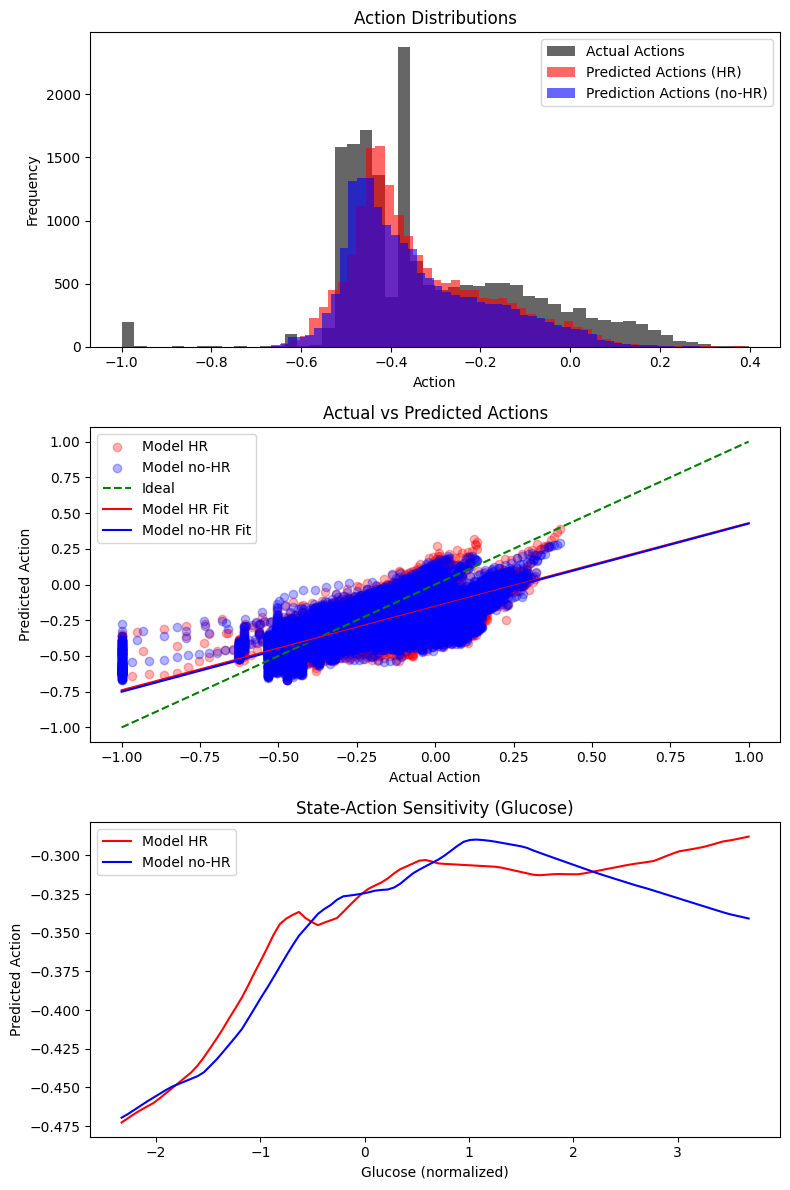


Model 1 Evaluation:
  Avg Q: -9.9713
  MSE: 0.0175
  Pearson Correlation: 0.7830
  R² Score: 0.5947
  Regression Line: slope=0.5847, intercept=-0.1551

Model 2 Evaluation:
  Avg Q: -9.9678
  MSE: 0.0178
  Pearson Correlation: 0.7856
  R² Score: 0.5875
  Regression Line: slope=0.5884, intercept=-0.1618


In [109]:
compare_two_models("modelSACCQL_epoch_200.pt", "modelSACCQL_noHR_epoch_200.pt", "datasets/processed/full-testing.csv")
